In [2]:
import os
import sys
import glob
import numpy as np
from tqdm import trange
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.convolution import convolve, Gaussian1DKernel
import astropy.units as u
import astropy.coordinates as coord
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Column
from tqdm import trange
import pandas as pd
import fitsio
from astropy.table import Table, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord
from easyquery import Query, QueryMaker
from scipy.stats import binomtest
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap, BoundaryNorm
import h5py
from astropy.cosmology import Planck18
import glob
from matplotlib.lines import Line2D
from matplotlib.patches import Circle

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

rootdir = '/global/u1/v/virajvm/'
sys.path.append(os.path.join(rootdir, 'DESI2_LOWZ/desi_dwarfs/code'))

from desi_lowz_funcs import make_subplots, match_c_to_catalog, print_radecs
from desi_lowz_funcs import calc_normalized_dist, sdss_rgb
from desi_lowz_funcs import find_objects_nearby
from construct_dwarf_galaxy_catalogs import process_sga_matches

%load_ext autoreload
%autoreload 2


In [27]:
import cmasher as cmr

Making plots using the main DESI sample (not SGA) updated photometry

# Plot of the pcnn values!


Make multi-survey panel showing how our imaging gets better 

In [178]:
import requests
from PIL import Image


# https://www.legacysurvey.org/viewer/fits-cutout?ra=175.8650&dec=52.7103&pixscale=0.5&layer=sdss

session = requests.Session()

def save_jpg(ra,dec,img_path,session,layer, size=128):
    url_prefix = 'https://www.legacysurvey.org/viewer/'
    
    url = url_prefix + f'cutout.jpg?ra={ra}&dec={dec}&size=%s&pixscale=0.262&'%size

    url += f'layer={layer}'
        
    resp = session.get(url)
    # Save the file
    with open(img_path, "wb") as f:
        f.write(resp.content)        

    return


def get_multi_survey_panel(ax, row_ind, ra, dec):
    '''
    # shred_cat[(shred_cat["RA"] > 148) & (shred_cat["RA"] < 152) & (shred_cat["DEC"] > 0) & (shred_cat["DEC"] < 4) & (shred_cat["Z"] < 0.03)]["RA","DEC","TARGETID"]

    149.45665462731105	2.0029896604254684
    149.91795726651713	3.2928921918890457
    148.1175	0.7725174662771342

    tgid_list=[39627835551256982,39627865754440424,39627805331294545  ]

    '''
    # https://www.legacysurvey.org/viewer?ra=149.91795726651713&dec=3.2928921918890457&layer=sdss&zoom=14
    # https://www.legacysurvey.org/viewer?ra=149.45665462731105&dec=2.0029896604254684&layer=hsc-dr3&zoom=14
    # https://www.legacysurvey.org/viewer?ra=149.45665462731105&dec=2.0029896604254684&layer=ls-dr10-grz&zoom=14
    # https://www.legacysurvey.org/viewer?ra=149.45665462731105&dec=2.0029896604254684&layer=ls-dr9&zoom=14

    if os.path.exists(f"plots/sdss_{row_ind}.jpg"):
        pass
    else:
        save_jpg(ra,dec,f"plots/sdss_{row_ind}.jpg",session,"sdss", size=128)
        save_jpg(ra,dec,f"plots/dr9_{row_ind}.jpg",session,"ls-dr9", size=128)
        save_jpg(ra,dec,f"plots/dr10_{row_ind}.jpg",session,"ls-dr10-grz", size=128)
        save_jpg(ra,dec,f"plots/hsc_{row_ind}.jpg",session,"hsc-dr3", size=128)
        
    # Load image
    sdss_img = Image.open(f"plots/sdss_{row_ind}.jpg")
    dr9_img = Image.open(f"plots/dr9_{row_ind}.jpg")
    dr10_img = Image.open(f"plots/dr10_{row_ind}.jpg")
    hsc_img = Image.open(f"plots/hsc_{row_ind}.jpg")

    ax[row_ind*4 + 0].imshow(sdss_img)
    ax[row_ind*4 + 1].imshow(dr9_img)
    ax[row_ind*4 + 2].imshow(dr10_img)
    ax[row_ind*4 + 3].imshow(hsc_img)


    for j in range(4):
        ax[row_ind*4 + j].set_xticks([])
        ax[row_ind*4 + j].set_yticks([])
        
    return
        

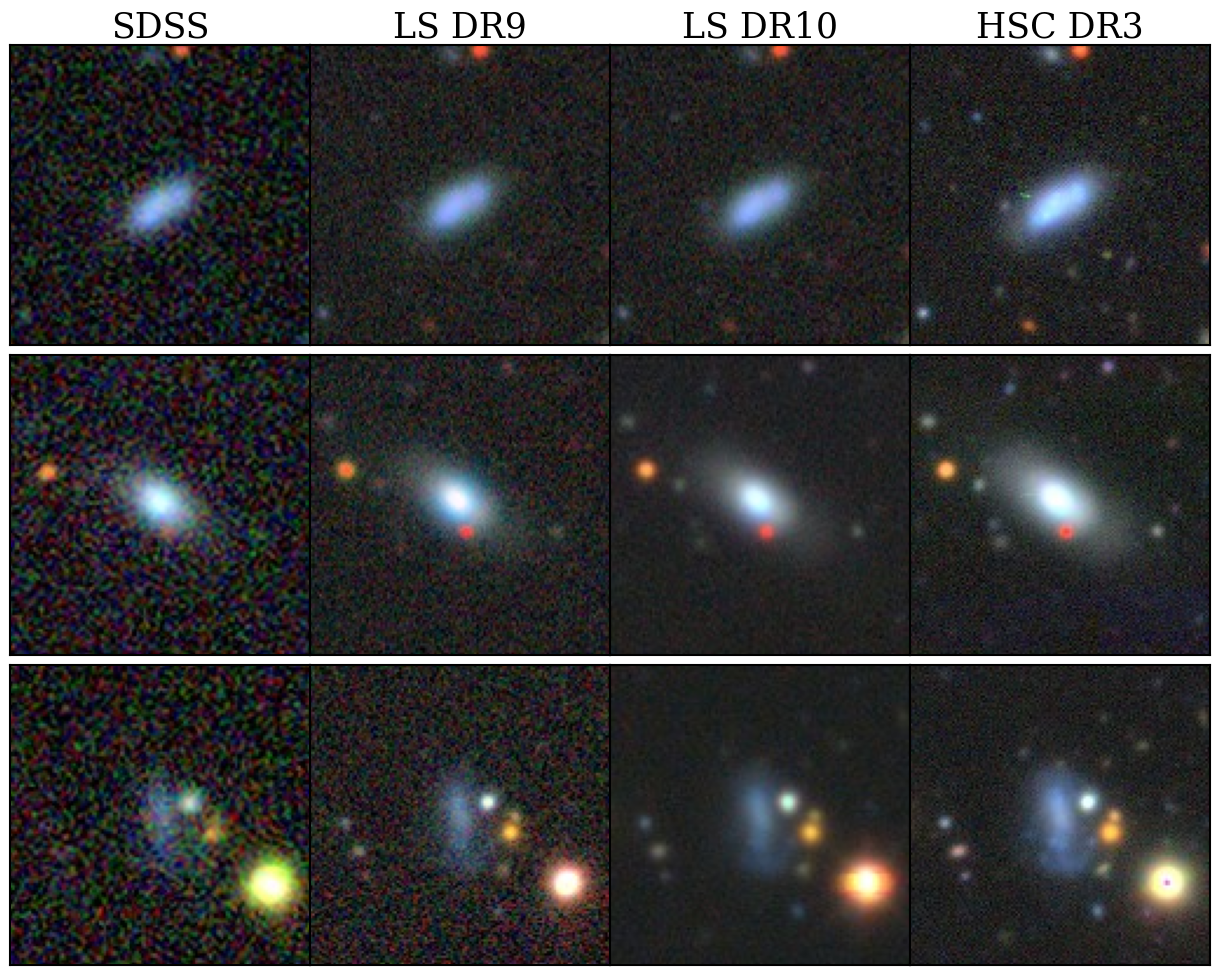

In [189]:

ra_list = [149.45665462731105,149.91795726651713, 148.1175 ]
dec_list = [2.0029896604254684,3.2928921918890457,0.7725174662771342  ]

fig,ax = make_subplots(ncol = 4,nrow = 3, return_fig=True,row_spacing = 0.1, col_spacing = 0.)

for row_ind in range(3):
    get_multi_survey_panel(ax, row_ind, ra_list[row_ind], dec_list[row_ind])

ax[8].set_title("SDSS",fontsize = 25)
ax[9].set_title("LS DR9",fontsize = 25)
ax[10].set_title("LS DR10",fontsize = 25)
ax[11].set_title("HSC DR3",fontsize = 25)

plt.savefig("plots/multi_survey_panel.pdf",bbox_inches="tight")

plt.show()

Make the multi-panel sample offset plot

In [57]:
import cmasher as cmr
from consolidate_photometry import consolidate_new_photo
from shred_photometry_maskbits import create_shred_maskbits_from_dict

def get_offsets(sample, clean=False):
    if clean:
        cat_type = "clean"
    else:
        cat_type = "shreds"
        
    file_path = f"/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_{sample}_{cat_type}_catalog_w_aper_mags.fits"
    
    data = Table.read(file_path)

    #consolidate them all!
    data = consolidate_new_photo(data,plot=False,sample=sample, add_pcnn=False)

    bitmasks_list = [0,1,2,3,4,5,6,7,8,9,10]
    cog_maskbits = create_shred_maskbits_from_dict(data, bitmasks_to_apply = bitmasks_list, verbose=True)

    bitmasks_list = [7,11,13,14]
    only_trac_maskbits = create_shred_maskbits_from_dict(data, bitmasks_to_apply = bitmasks_list,mag_type="_BEST", verbose=True)
    
    #we want to filter out the sources where we think COG might be unreliable?
    # data = data[data["PHOTO_MASKBIT"] == 0]
    # data = data[(photo_maskbits == 0) & data["PHOTO_MASKBIT"] == 0]
    data = data[(cog_maskbits == 0) & (only_trac_maskbits==0) ]
    
    all_fracfluxs = np.concatenate( (data["FRACFLUX_G"],data["FRACFLUX_R"],data["FRACFLUX_Z"]  ) ) 
    
    best_offsets = np.concatenate( (data[f"MAG_G_BEST"].data - data["MAG_G"].data ,data[f"MAG_R_BEST"].data - data["MAG_R"].data ,data[f"MAG_Z_BEST"].data - data["MAG_Z"].data   ) )
    aper_offsets = np.concatenate( (data[f"COG_MAG_G_FINAL"].data - data["MAG_G"].data ,data[f"COG_MAG_R_FINAL"].data - data["MAG_R"].data ,data[f"COG_MAG_Z_FINAL"].data - data["MAG_Z"].data   ) )
    
    best_mags = np.concatenate( (data[f"MAG_G_BEST"].data,data[f"MAG_R_BEST"].data,data[f"MAG_Z_BEST"].data) )
    aper_mags = np.concatenate( (data[f"COG_MAG_G_FINAL"].data,data[f"COG_MAG_R_FINAL"].data,data[f"COG_MAG_Z_FINAL"].data) )
    
    trac_mags = np.concatenate( (data["MAG_G"].data, data["MAG_R"].data, data["MAG_Z"].data  ) )
    
    all_fracfluxs = all_fracfluxs[~np.isnan(aper_offsets)]

    best_offsets = best_offsets[~np.isnan(aper_offsets)]
    aper_mags = aper_mags[~np.isnan(aper_offsets)]
    
    aper_offsets = aper_offsets[~np.isnan(aper_offsets)]
    
    return all_fracfluxs, aper_offsets, best_offsets, aper_mags, trac_mags


  

In [58]:

##load the shred aperture results
ff_bgsb, dm_aper_bgsb, dm_best_bgsb, _, _ = get_offsets(sample = "BGS_BRIGHT", clean=False)
ff_bgsf, dm_aper_bgsf, dm_best_bgsf, _, _ = get_offsets(sample = "BGS_FAINT", clean=False)
ff_elg, dm_aper_elg, dm_best_elg, _, _ = get_offsets(sample = "ELG", clean=False)
ff_lowz, dm_aper_lowz, dm_best_lowz, _, _ = get_offsets(sample = "LOWZ", clean=False)

#load the clean aperture results. The number of galaxies here is meant to be the same as the shred ones to have a one-to-one comparison 
ff_bgsb_c, dm_aper_bgsb_c, dm_best_bgsb_c, _, trac_mag_bgsb_c = get_offsets(sample = "BGS_BRIGHT", clean=True)
ff_bgsf_c, dm_aper_bgsf_c, dm_best_bgsf_c, _, trac_mag_bgsf_c = get_offsets(sample = "BGS_FAINT", clean=True)
ff_elg_c, dm_aper_elg_c, dm_best_elg_c, _, trac_mag_elg_c = get_offsets(sample = "ELG", clean=True)
ff_lowz_c, dm_aper_lowz_c, dm_best_lowz_c, _, trac_mag_lowz_c = get_offsets(sample = "LOWZ", clean=True)


Need to rerun the shred catalog after having fixed the column name
Not adding the PCNN values! Adding all 1.
<class 'numpy.ndarray'>
<class 'astropy.table.column.Column'>
<class 'astropy.table.column.Column'>
<class 'astropy.table.column.Column'>
[False False False False False]
FRACTION REVERT BACK TO TRACTOR: 0.21886002474069846
Need to include the VI column that only does the aperture no subtract photo
Adding the photo maskbits
MASKBIT=2^0, cog nan mask, 0.0031
MASKBIT=2^1, cog not converge, fraction: 0.059806
MASKBIT=2^2, bad resid, fraction : 0.0070
MASKBIT=2^3, cog curve decrease, fraction: 0.0124
MASKBIT=2^4, aperfrac-in image, fraction: 0.001570
MASKBIT=2^5, aperfrac-mask image, fraction: 0.047340
MASKBIT=2^6, image-frac mask, fraction: 0.000809
MASKBIT=2^7, bad colors, fraction: 0.000428
MASKBIT=2^8, source not on segment, fraction: 0.0000
MASKBIT=2^9, within star mask radius and not just a simple blend, fraction: 0.102151
MASKBIT=2^10, aper-cen masked, fraction: 0.049339
MASKB

In [59]:
def combine_clean_shred(ff_bgsb, ff_bgsb_c, dm_bgsb, dm_bgsb_c):  
    ff_bgsb_all = np.concatenate([ff_bgsb, ff_bgsb_c])
    dm_bgsb_all = np.concatenate([dm_bgsb, dm_bgsb_c])

    return ff_bgsb_all, dm_bgsb_all

ff_bgsb_all, dm_aper_bgsb_all = combine_clean_shred(ff_bgsb, ff_bgsb_c, dm_aper_bgsb, dm_aper_bgsb_c )
ff_bgsf_all, dm_aper_bgsf_all = combine_clean_shred(ff_bgsf, ff_bgsf_c, dm_aper_bgsf, dm_aper_bgsf_c )
ff_lowz_all, dm_aper_lowz_all = combine_clean_shred(ff_lowz, ff_lowz_c, dm_aper_lowz, dm_aper_lowz_c )
ff_elg_all, dm_aper_elg_all = combine_clean_shred(ff_elg, ff_elg_c, dm_aper_elg, dm_aper_elg_c )

_, dm_best_bgsb_all = combine_clean_shred(ff_bgsb, ff_bgsb_c, dm_best_bgsb, dm_best_bgsb_c )
_, dm_best_bgsf_all = combine_clean_shred(ff_bgsf, ff_bgsf_c, dm_best_bgsf, dm_best_bgsf_c )
_, dm_best_lowz_all = combine_clean_shred(ff_lowz, ff_lowz_c, dm_best_lowz, dm_best_lowz_c )
_, dm_best_elg_all = combine_clean_shred(ff_elg, ff_elg_c, dm_best_elg, dm_best_elg_c )



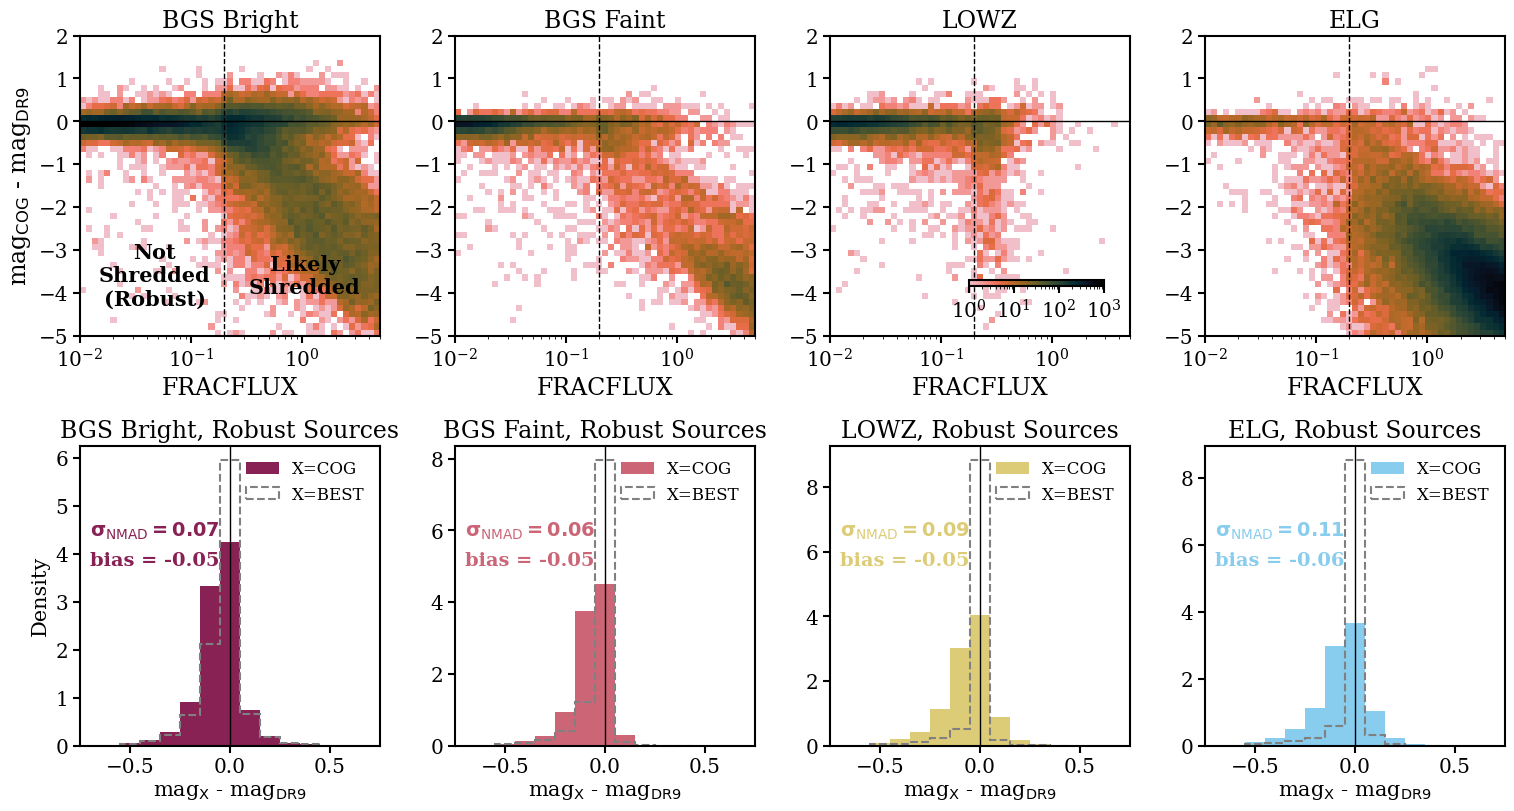

In [83]:

bins = 50
    
ax = make_subplots(ncol =4, nrow = 2, col_spacing = 0.75)
    
fs = 17


vmax = 1000
vmin = 1

h, xedges, yedges, im = ax[4].hist2d(ff_bgsb_all, dm_aper_bgsb_all, range = ( (1e-2, 5,), (-5, 2) ),
             bins = [ np.logspace(-2, np.log10(5), bins), np.linspace(-5,2,bins) ],norm=LogNorm(vmin=vmin,vmax = vmax),
            cmap = cmr.dusk_r)

h, xedges, yedges, im = ax[5].hist2d(ff_bgsf_all, dm_aper_bgsf_all, range = ( (1e-2, 5,), (-5, 2) ),
             bins = [ np.logspace(-2, np.log10(5), bins), np.linspace(-5,2,bins) ],norm=LogNorm(vmin=vmin,vmax = vmax),
            cmap = cmr.dusk_r)

h, xedges, yedges, im = ax[6].hist2d(ff_lowz_all, dm_aper_lowz_all, range = ( (1e-2, 5,), (-5, 2) ),
             bins = [ np.logspace(-2, np.log10(5), bins), np.linspace(-5,2,bins) ],norm=LogNorm(vmin=vmin,vmax = vmax),
            cmap = cmr.dusk_r)

h, xedges, yedges, im = ax[7].hist2d(ff_elg_all, dm_aper_elg_all, range = ( (1e-2, 5,), (-5, 2) ),
             bins = [ np.logspace(-2, np.log10(5), bins), np.linspace(-5,2,bins) ],norm=LogNorm(vmin=vmin,vmax = vmax),
            cmap = cmr.dusk_r)

ax[4].set_title("BGS Bright",fontsize = fs)
ax[5].set_title("BGS Faint",fontsize = fs)
ax[6].set_title("LOWZ",fontsize = fs)
ax[7].set_title("ELG",fontsize = fs)

for i in range(4,8):
    ax[i].hlines(y = 0,xmin=1e-2, xmax = 5,ls = "-",color = "k",lw =1 )
    ax[i].vlines(x = 0.2, ymin = -5, ymax = 2, color= "k", ls = "--",lw = 1)
    ax[i].set_xlabel(r"FRACFLUX",fontsize = fs)
    if i == 4:
        ax[i].set_ylabel(r"mag$_{\rm COG}$ - mag$_{\rm DR9}$",fontsize = fs)
    else:
        pass
        # ax[i].set_ylabel(r"$\Delta m$",fontsize = 15)
        
    ax[i].set_xlim([1e-2, 5])
    ax[i].set_ylim([-5,2])
    ax[i].set_xscale("log")
    
#insert a colorbar
colbar_x, colbar_y = 0.6425, 0.465

cbar = plt.colorbar(im, ax=ax[5], orientation='horizontal', pad=0.05)
cbar.ax.set_position([
colbar_x,   # Left position
colbar_y,  # Top position
ax[5].get_position().width * 0.09,  # Width (40% of plot width)
0.015  # Height (thin bar)
])

bins = 10

sample_color_map = {"BGS_BRIGHT" : "#882255", "BGS_FAINT": "#CC6677", "LOWZ":"#DDCC77", "ELG": "#88CCEE" }

mag_min=-0.5
mag_max=0.5

bins=np.arange(-0.55,0.55,0.1)

lw = 1.5

cog_label = "X=COG"
best_label = "X=BEST"

ax[0].hist(dm_aper_bgsb_c, range = (mag_min,mag_max), bins = bins,density=True,color = sample_color_map["BGS_BRIGHT"], label=cog_label )
ax[0].hist(dm_best_bgsb_c, range = (mag_min,mag_max), bins = bins,density=True,color = "grey",histtype="step",lw=lw,ls="--", label =best_label )

ax[1].hist(dm_aper_bgsf_c, range = (mag_min,mag_max), bins = bins,density=True,color = sample_color_map["BGS_FAINT"], label=cog_label )
ax[1].hist(dm_best_bgsf_c, range = (mag_min,mag_max), bins = bins,density=True,color = "grey",histtype="step",lw=lw,ls="--", label =best_label )

ax[2].hist(dm_aper_lowz_c, range = (mag_min,mag_max), bins = bins,density=True,color = sample_color_map["LOWZ"],label=cog_label )
ax[2].hist(dm_best_lowz_c, range = (mag_min,mag_max), bins = bins,density=True,color = "grey",histtype="step",lw=lw,ls="--", label =best_label )


ax[3].hist(dm_aper_elg_c, range = (mag_min,mag_max), bins = bins,density=True,color = sample_color_map["ELG"], label=cog_label )
ax[3].hist(dm_best_elg_c, range = (mag_min,mag_max), bins = bins,density=True,color = "grey",histtype="step",lw=lw,ls="--", label =best_label )

for i in range(4):
    ax[i].legend(frameon=False,loc="upper right",fontsize = 12)


ax[0].set_title("BGS Bright, Robust Sources",fontsize = fs)
ax[1].set_title("BGS Faint, Robust Sources",fontsize = fs)
ax[2].set_title("LOWZ, Robust Sources",fontsize = fs)
ax[3].set_title("ELG, Robust Sources",fontsize = fs)

ax[0].set_ylabel("Density",fontsize = 15)
for i in range(4):
    ax[i].set_xlim([-0.75,0.75])
    ax[i].axvline(x = 0,color = "k",lw = 1)
    ax[i].set_xlabel(r"mag$_{\rm X}$ - mag$_{\rm DR9}$",fontsize = 15)


xpos = 0.035
ypos = 0.7

def add_text_label_func(ax_ind, dm_objs, sample):
    sigma_nmad = stats.median_abs_deviation(dm_objs, scale='normal')
    ax[ax_ind].text(
        xpos, ypos,
        rf"$\mathbf{{\sigma_{{\rm{{NMAD}}}} = {sigma_nmad:.2f}}}$",
        fontsize=14,
        transform=ax[ax_ind].transAxes,
        color=sample_color_map[sample]
    )
    
    ax[ax_ind].text(xpos,ypos-0.1, f"bias = {np.median(dm_objs):.2f}",
           fontsize = 14, transform = ax[ax_ind].transAxes,color = sample_color_map[sample],weight="bold")


    return

    
add_text_label_func(0, dm_aper_bgsb_c, "BGS_BRIGHT")
add_text_label_func(1, dm_aper_bgsf_c, "BGS_FAINT")
add_text_label_func(2, dm_aper_lowz_c, "LOWZ")
add_text_label_func(3, dm_aper_elg_c, "ELG")


ax[4].text(0.25,0.2,"Not\nShredded\n(Robust)",fontsize = 15, transform = ax[4].transAxes, 
           ha='center', va='center',weight="bold")
ax[4].text(0.75,0.2,"Likely\nShredded",fontsize = 15, transform = ax[4].transAxes,
           ha='center', va='center',weight="bold")

plt.savefig("plots/fracflux_delta_mag.pdf",bbox_inches="tight")

plt.show()


        

In [84]:
# # ## maybe this is as a function of magnitude??

# all_trac_mags = np.concatenate([ trac_mag_bgsb_c,trac_mag_bgsf_c, trac_mag_lowz_c, trac_mag_elg_c])
# all_dms_c = np.concatenate([ dm_bgsb_c,dm_bgsf_c, dm_lowz_c, dm_elg_c])

# # plt.hist2d(all_trac_mags , all_dms_c, range = ( (15,23), (-1.5,1.5)), bins = 50,
# #          cmap = cmr.dusk_r, norm=LogNorm())


# # plt.show()

In [85]:
# np.sum(all_dms_c < -1)/len(all_dms_c)

In [86]:
# from desi_lowz_funcs import get_contours

# cont_dict = get_contours(all_trac_mags , all_dms_c,np.arange(16,23.5,0.25),sigs=True)

In [87]:
# cont_dict.keys()

In [88]:
# fig,ax = make_subplots(ncol = 1, nrow = 1,return_fig=True)

# ax[0].set_title("DESI DR1, Clean Sources",fontsize = 15)

# ax[0].axhline(y = 0,color = "k",lw = 1,ls = "dotted")
# ax[0].plot(cont_dict["bin_cents"], cont_dict["median"], color = "mediumblue", lw=2 )
# ax[0].fill_between(cont_dict["bin_cents"], y1 = cont_dict["sig1_low"], y2 = cont_dict["sig1_high"], 
#                    alpha = 0.25, color = "mediumblue" ,edgecolor = "none"  )
# ax[0].fill_between(cont_dict["bin_cents"], y1 = cont_dict["sig2_low"], y2 = cont_dict["sig2_high"], 
#                    alpha = 0.125, color = "mediumblue",edgecolor = "none"  ) 

# ax[0].set_xticks([17,18,19,20,21,22,23])
# ax[0].set_xlabel(r"mag$_{\rm DR9}$",fontsize = 15)
# ax[0].set_ylabel(r"mag$_{\rm aper}$ - mag$_{\rm DR9}$",fontsize = 15)
# ax[0].set_ylim([-1,1])
# ax[0].set_xlim([17,23])

# plt.savefig("plots/tractor_mag_compare_clean.pdf",bbox_inches="tight")

# plt.show()

## Compare tractor sizes!

In [ ]:
from consolidate_photometry import consolidate_new_photo, consolidate_positions_and_shapes

##load the clean catalog and compare the shape_r and aper_params?

## we need to consolidate the photometry

def get_clean_catalog_stats():
    samps = ["BGS_BRIGHT","BGS_FAINT","LOWZ","ELG"]

    data_dict = {}
    
    for sampi in samps:
        bgsb_clean_path = f"/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_{sampi}_clean_catalog_w_aper_mags.fits"
        bgsb_c_cat = Table.read(bgsb_clean_path)
        
        bgsb_c_cat = consolidate_new_photo(bgsb_c_cat,plot=False,sample=sampi, add_pcnn=False)

        print("ADDING SIZE AND SHAPE INFO")
        bgsb_c_cat = consolidate_positions_and_shapes(bgsb_c_cat)
        
        print(len(bgsb_c_cat))
        # bgsb_c_cat = bgsb_c_cat[(bgsb_c_cat["PHOTO_MASKBIT"] == 0) & (bgsb_c_cat["MAG_TYPE"] != "TRACTOR_ORIGINAL")] 
        bgsb_c_cat = bgsb_c_cat[(bgsb_c_cat["PHOTO_MASKBIT"] == 0) ] 

        print(len(bgsb_c_cat))
        
        r_eff_new = bgsb_c_cat["R50_R"].data
        
        # #deconvolve approximatelyt with the seeing
        # r_eff_cog_new = np.sqrt( r_eff_cog**2 - 0**2 )

        data_dict[sampi] = { "SHAPE_R": bgsb_c_cat["SHAPE_R"].data, "R50_R": r_eff_new, "table": bgsb_c_cat  }

    return data_dict
        


In [ ]:
clean_size_dict = get_clean_catalog_stats()

In [ ]:
# from desi_lowz_funcs import get_contours

# size_conts = get_contours(clean_size_dict["BGS_BRIGHT"]["SHAPE_R"],  clean_size_dict["BGS_BRIGHT"]["R5"], 
#              bins=np.arange(0,20,1),sigs=True)

# size_conts.keys()

dict_keys(['bin_cents', 'median', 'sig1_low', 'sig1_high', 'sig2_low', 'sig2_high'])

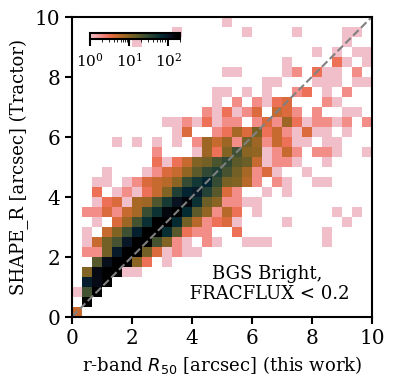

In [45]:
#we compare only the BGS Bright

ax = make_subplots(ncol = 1 , nrow = 1)

im = ax[0].hist2d(clean_size_dict["BGS_BRIGHT"]["SHAPE_R_new"] ,clean_size_dict["BGS_BRIGHT"]["SHAPE_R"], 
             range=((0,10),(0,10)), bins=30,norm=LogNorm(vmin=1, vmax=200), 
             cmap=cmr.dusk_r,rasterized=True)

# ax[0].fill_between(x = size_conts["bin_cents"], y1 = size_conts["sig2_low"], y2 = size_conts["sig2_high"], color = "darkgreen",alpha=0.25  )
# ax[0].fill_between(x = size_conts["bin_cents"], y1 = size_conts["sig1_low"], y2 = size_conts["sig1_high"], color = "darkgreen",alpha=0.5  )

# ax[0].plot(size_conts["bin_cents"], size_conts["sig2_high"])
# ax[0].plot(size_conts["bin_cents"], size_conts["sig2_low"])

ax[0].set_ylim([0,10])
ax[0].set_xlim([0,10])
ax[0].set_xlabel("")
ax[0].set_ylabel(r"SHAPE_R [arcsec] (Tractor)",fontsize = 13)
ax[0].set_xlabel(r"r-band $R_{50}$ [arcsec] (this work)",fontsize = 13)

ax[0].plot([0,50],[0,50],color = "grey",ls="--")

cbar_ax = ax[0].inset_axes([0.06, 0.925, 0.3, 0.02])  # relative to ax_top
cbar = plt.colorbar(im[3], cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=11)

ax[0].text(6.5,0.6,"BGS Bright,\n FRACFLUX < 0.2",fontsize =13,color="k",ha="center")

plt.savefig("plots/tractor_clean_size_comparison.pdf",bbox_inches="tight")

plt.show()


